TODO LO QUE HAY QUE HACER ES:

PARA PREPROCESAMIENTO:

- convertir a faltantes los 'Asked but unknown', ...
- comprobar las variables derivadas (fórmulas)
- agrupar las columnas de opción múltiple en una única columna
- cambiar los nombres de las columnas para que aparezcan como las variables del diccionario
- convertir las columnas 'sí'/'no' a objeto como 1/0
- convertir las columnas de dieta, estrés, etc de objeto a float
- anotar las variables numéricas que son ordinales (nivel bajo / nivel alto)

PARA MISSINGS:

- del dataset limpio sacar las columnas con <20% de missings y las columnas con 20-35% de missings

PARA ESTADÍSTICAS: 

- de las variables numéricas y de las variables categóricas (crear csv en el que se almacenen los resultados)

# PREPROCESAMIENTO DE DATOS

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import html
import re
import unicodedata

In [ ]:
# Cargamos el dataset
try:
    # Se intenta cargar desde el directorio actual (para cuando usamos Colab)
    file_path = 'variables_CARDIOMOM.xlsx'
    df = pd.read_excel(file_path)
except FileNotFoundError:
    # Si falla, se intenta la ruta seguir relativa local (estructura de carpetas original)
    file_path = '../variables_CARDIOMOM.xlsx'
    df = pd.read_excel(file_path)

print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

Dataset cargado con 608 filas y 478 columnas.


In [157]:
# Observamos que, en el dataset, el último ID es 662. Sin embargo, hay 608 registros. Entonces, comprobamos si la diferencia de filas se debe a huecos en los IDs.
if 'ID' in df.columns:
    col_id = 'ID'
    max_id = df[col_id].max()
    unique_ids = df[col_id].nunique()
    print(f"Análisis de IDs para verificar integridad:")
    print(f"- ID Máximo encontrado en el archivo: {max_id}")
    print(f"- Total de filas cargadas (pacientes): {unique_ids}")
    print(f"- Diferencia (IDs faltantes/huecos): {max_id - unique_ids}")
    
    # Listar algunos IDs que faltan si hay huecos
    if max_id > unique_ids:
        all_ids = set(range(1, max_id + 1))
        present_ids = set(df[col_id].unique())
        missing = sorted(list(all_ids - present_ids))
        print(f"- Ejemplos de IDs que NO existen en el Excel: {missing[:10]}...")

Análisis de IDs para verificar integridad:
- ID Máximo encontrado en el archivo: 662
- Total de filas cargadas (pacientes): 608
- Diferencia (IDs faltantes/huecos): 54
- Ejemplos de IDs que NO existen en el Excel: [24, 30, 31, 37, 38, 74, 83, 85, 90, 110]...


## Sanitización de los datos

In [181]:
# Creamos una función para sanitizar los datos.
# Lo que se hará es:
# 1. Limpiar la basura ('Not applicable', 'Not asked', etc.)
# 2. Eliminar espacios y estandarizar mayúsculas (Capitalize)
# 3. Convertir columnas de 'Fecha' a datetime
# 4. Convertir el resto a numérico si es posible

# Después de aplicar esta función, el dataframe resultante será df_clean

def sanitizar_datos(df_in):
    df_out = df_in.copy()
    
    # Limpieza de texto
    cols_obj = df_out.select_dtypes(include=['object']).columns
    for col in cols_obj:
        # Estandarizar texto:
        df_out[col] = df_out[col].astype(str).str.strip().str.capitalize()
        
        # Restaurar NaNs reales (astype(str) convierte NaN en 'nan')
        df_out.loc[df_out[col] == 'Nan', col] = np.nan # Capitalize convierte 'nan' en 'Nan'
        df_out.loc[df_out[col] == 'nan', col] = np.nan
        
        # Convertir a NaNs los valores que son considerados basura:
        blacklist = [
            '[not completed]', 'Asked but unknown', 'Not applicable', 'Not available', 'Not asked', 
            'Nan', 'None', '', 'Unknown', 'N/a', 'No determinado'
        ]
        df_out[col] = df_out[col].replace(blacklist, np.nan)

    # Limpieza de fechas
    cols_fecha = [c for c in df_out.columns if 'fecha' in c.lower() or 'date' in c.lower() or 'timestamp' in c.lower()]
    for col in cols_fecha:
        # Convertir las fechas a tipo datetime, ignorando errores
        df_out[col] = pd.to_datetime(df_out[col], errors='coerce')

    # Intentar convertir a numérico el resto
    cols_no_fecha = [c for c in df_out.columns if c not in cols_fecha]
    for col in cols_no_fecha:
        try:
            df_out[col] = pd.to_numeric(df_out[col])
        except (ValueError, TypeError):
            pass

    return df_out

print('Se está ejecutando la sanitización de los datos (Fechas, Capitalize y Blacklist)')
df_clean = sanitizar_datos(df)


Se está ejecutando la sanitización de los datos (Fechas, Capitalize y Blacklist)


In [232]:
df_clean.to_csv('limpiio.csv')

## Recálculo de las variables derivadas

In [234]:
# Recalculamos las variables derivadas para comprobar que son correctas
comprobaciones = [
    {
        "nombre": "IMC inicio gestación",
        "col_resultado": "IMC inicio gestación",
        "dependencias": ["Peso inicio gestación (kg)", "Talla (cm)"],
        "formula": lambda d: d["Peso inicio gestación (kg)"] / ((d["Talla (cm)"] / 100) ** 2)
    },
    {
        "nombre": "IMC actual",
        "col_resultado": "IMC actual",
        "dependencias": ["Peso actual (kg)", "Talla (cm)"],
        "formula": lambda d: d["Peso actual (kg)"] / ((d["Talla (cm)"] / 100) ** 2)
    },
    {
        "nombre": "Aumento de peso durante gestación",
        "col_resultado": "Aumento de peso durante gestación (kg)",
        "dependencias": ["Peso final en gestación (kg)", "Peso inicio gestación (kg)"],
        "formula": lambda d: d["Peso final en gestación (kg)"] - d["Peso inicio gestación (kg)"]
    },
    {
        "nombre": "Ratio sFlt-1/PlGF",
        "col_resultado": "Ratio sFlt-1/PlGF",
        "dependencias": ["Valor de sFlt-1 (pg/ml)", "Valor de PlGF (pg/ml)"],
        "formula": lambda d: d["Valor de sFlt-1 (pg/ml)"] / d["Valor de PlGF (pg/ml)"]
    },
    {
        "nombre": "Ratio Cintura/Cadera",
        "col_resultado": "Ratio cintura/cadera",
        "dependencias": ["Perímetro de la cintura (cm)", "Perímetro de la cadera (cm)"],
        "formula": lambda d: d["Perímetro de la cintura (cm)"] / d["Perímetro de la cadera (cm)"]
    }
]

for comp in comprobaciones:
    res_col = comp["col_resultado"]
    deps = comp["dependencias"]
    
    # Verificamos si todas las columnas necesarias existen
    if all(c in df_clean.columns for c in [res_col] + deps):
        try:
            # Calculamos el valor esperado
            esperado = comp["formula"](df_clean)
            real = df_clean[res_col]
            
            # Filtramos filas donde tengamos tanto el dato real como los ingredientes para el esperado
            mask = real.notna() & esperado.notna()
            
            if mask.any():
                # Comparamos con una tolerancia de 0.01 por posibles redondeos
                es_igual = np.isclose(real[mask], esperado[mask], atol=0.01)
                errores = len(es_igual) - es_igual.sum()
                
                if errores == 0:
                    print(f"{comp['nombre']}: Todo correcto.")
                else:
                    print(f"{comp['nombre']}: Se han encontrado {errores} discrepancias.")
            else:
                print(f"{comp['nombre']}: No hay datos suficientes (NaNs) para comparar.")
                
        except Exception as e:
            print(f"Error al procesar {comp['nombre']}: {e}")
    else:
        faltan = [c for c in [res_col] + deps if c not in df_clean.columns]
        print(f"{comp['nombre']}: Faltan columnas en el DF: {faltan}")

IMC inicio gestación: Todo correcto.
IMC actual: Todo correcto.
Aumento de peso durante gestación: Todo correcto.
Ratio sFlt-1/PlGF: Todo correcto.
Ratio Cintura/Cadera: Todo correcto.


## Consolidar opciones múltiples

In [224]:
# Creamos una función para consolidar las opciones múltiples del dataset. 
# De esta forma, se crea un nuevo df (df_clean_consolidado), de tamaño (608, 433) a partir del df_clean (608, 478).

def consolidar_opciones_multiples(df):
    # Buscar columnas con el patrón '(choice='
    cols_opciones = [col for col in df.columns if '(choice=' in col]
    
    # Extraer prefijos únicos (nombres de variables)
    # Usamos sorted(list(set(...))) para que el orden sea siempre el mismo
    prefijos = sorted(list(set([col.split(' (choice=')[0] for col in cols_opciones])))
    
    print(f"Se encontraron {len(prefijos)} grupos de variables para consolidar: {prefijos}")
    
    for prefijo in prefijos:
        # Obtener todas las columnas para este prefijo
        cols_relevantes = [col for col in cols_opciones if col.startswith(prefijo + ' (choice=')]
        
        # Crear una nueva columna de tipo objeto para almacenar los valores consolidados
        nombre_nueva_col = prefijo
        df[nombre_nueva_col] = np.nan
        df[nombre_nueva_col] = df[nombre_nueva_col].astype('object')
        
        
        for col in cols_relevantes:
            # Extraer el valor del nombre de la columna
            valor = col.split('(choice=')[1].replace(')', '')
            
            # Identificar filas donde esta opción está marcada
            mascara = df[col] == 'Checked'
            
            mask_new = mascara & df[nombre_nueva_col].isna()
            if mask_new.any():
                df.loc[mask_new, nombre_nueva_col] = valor
        
        # Eliminar las columnas originales para limpiar
        df.drop(columns=cols_relevantes, inplace=True)
    
    return df, list(prefijos)


df_clean_consolidado, nuevas_variables = consolidar_opciones_multiples(df_clean.copy())

Se encontraron 6 grupos de variables para consolidar: ['Estudio inicial', 'Localización', 'Motivo inducción', 'Tomó alguna durante la gestación?', 'Tratamiento para la diabetes', '¿Cuál de ellas?']


In [225]:
# Observamos que hay algunas columnas con nombres mal formados (caracteres HTML no deseados)

# Detectamos una columna con caracteres raros HTML (&nbsp;)
# "Score total< 4:&nbsp;dependencia&nbsp;&nbsp;baja&nbsp;4-6: dependencia&nbsp;media&nbsp;&nbsp;>7:&nbsp;dependencia&nbsp;alta&nbsp;"
col_rara = [c for c in df_clean_consolidado.columns if 'Score total' in c and 'dependencia' in c]
if col_rara:
    nombre_viejo = col_rara[0]
    nombre_nuevo = "Score Dependencia Tabaco (Fagersxtröm)"
    print(f"Renombrando columna mal formada (es numérica, el nombre original tenía la leyenda):\n- '{nombre_viejo}'\n-> '{nombre_nuevo}'")
    df_clean_consolidado.rename(columns={nombre_viejo: nombre_nuevo}, inplace=True)

# También detectamos 'Queso&nbsp;(1 porción)'
col_queso = [c for c in df_clean_consolidado.columns if 'Queso' in c and '&nbsp;' in c]
if col_queso:
    print(f"Limpiando nombre de columna 'Queso':")
    df_clean_consolidado.rename(columns={col_queso[0]: 'Queso (1 porción)'}, inplace=True)


Renombrando columna mal formada (es numérica, el nombre original tenía la leyenda):
- 'Score total< 4:&nbsp;dependencia&nbsp;&nbsp;baja&nbsp;4-6: dependencia&nbsp;media&nbsp;&nbsp;>7:&nbsp;dependencia&nbsp;alta&nbsp;'
-> 'Score Dependencia Tabaco (Fagersxtröm)'
Limpiando nombre de columna 'Queso':


## Cambiar los nombres de las columnas de acuerdo con el diccionario

In [226]:
# Renombramos las columnas usando diccionario25enero.md

def normalize_text(s):
    if s is None:
        return ''
    s = str(s)
    
    # 1. Decodificar entidades HTML y limpiar espacios especiales (\xa0)
    s = html.unescape(s)
    s = s.replace('\xa0', ' ')
    
    # 2. Estandarizar símbolos de comparación para que no se borren
    s = s.replace('≥', '>=').replace('≤', '<=')
    
    # 3. Quitar acentos (diacríticos)
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    
    # 4. Mantener alfanuméricos y símbolos clave que diferencian variables
    # IMPORTANTE: Hemos añadido '¿' a la lista
    s = re.sub(r'[^0-9a-zA-Z()<>=\.\?\¿\+\s]', ' ', s)
    
    # 5. Limpiar espacios múltiples pero NO pasar a minúsculas (lower) 
    # para poder distinguir "Fecha Última Regla" de "Fecha última regla"
    # si el diccionario así lo requiere.
    s = ' '.join(s.split()).strip()
    
    return s


def extraer_mapeo_desde_md_normalizado(ruta_md):
    raw_map = {}
    with open(ruta_md, 'r', encoding='utf-8') as f:
        lineas = f.readlines()

    pattern = r"\*\*(.*?)\*\*\s*\|\s*`([^`]+)`"

    for linea in lineas:
        match = re.search(pattern, linea)
        if match:
            nombre_original = match.group(1).strip()
            nombre_propuesto = match.group(2).strip()
            nombre_original_limpio = html.unescape(nombre_original)
            nombre_original_limpio = ' '.join(nombre_original_limpio.split())
            raw_map[nombre_original_limpio] = nombre_propuesto

    # Normalizar claves
    norm_map = {}
    collisions = {}
    for orig, prop in raw_map.items():
        key = normalize_text(orig)
        if key in norm_map and norm_map[key] != prop:
            # registrar colisiones
            collisions.setdefault(key, set()).update([norm_map[key], prop])
        else:
            norm_map[key] = prop

    return raw_map, norm_map, collisions

# Extraer mapeo desde diccionario (normalizado)
raw_map, norm_map, collisions = extraer_mapeo_desde_md_normalizado('diccionario25enero.md')
if collisions:
    # print(f"Colisiones encontradas en normalización: {len(collisions)}")
    for i, (k, v) in enumerate(collisions.items()):
        if i >= 5:
            break
        print(f"  - {k}: {v}")

# Limpiar nombres de columnas actuales
def limpiar_nombre_columna(nombre):
    nombre = html.unescape(nombre)
    nombre = ' '.join(nombre.split())
    return nombre.strip()

cols_clean = [limpiar_nombre_columna(col) for col in df_clean_consolidado.columns]
# Aplicar limpieza a df
df_clean_consolidado.columns = cols_clean

# Mapear usando normalización
columnas_renombradas = {}
columnas_no_encontradas = []
aplicadas = []

for col in cols_clean:
    key = normalize_text(col)
    if key in norm_map:
        columnas_renombradas[col] = norm_map[key]
        aplicadas.append((col, norm_map[key]))
    else:
        columnas_no_encontradas.append(col)

# Crear nuevo dataframe renombrado
df_clean_consolidado_renombrado = df_clean_consolidado.rename(columns=columnas_renombradas)

print(f"Se han renombrado {len(aplicadas)} variables")
print(f"Forma nueva: {df_clean_consolidado_renombrado.shape}")


# Exponer variables para uso posterior
mapeo_md_raw = raw_map
mapeo_md_normalized = norm_map
columna_no_encontradas = columnas_no_encontradas


Se han renombrado 433 variables
Forma nueva: (608, 439)


## Convertir todas las variables 'Sí'/'No' en 1/0

In [195]:
# Creamos una función para convertir las columnas que contienen 'Sí'/'No' o 'Yes'/'No' a 1/0

def convertir_si_no_a_binario(df):
    df_out = df.copy()
    
    cols_convertidas = []
    
    # Iterar sobre cada columna de tipo object
    cols_obj = df_out.select_dtypes(include=['object']).columns
    
    for col in cols_obj:
        # Obtener valores únicos de la columna (excluyendo NaN)
        col_dropna = df_out[col].dropna()
        
        if len(col_dropna) == 0:  # Si la columna está completamente vacía, saltar
            continue
        
        # Obtener valores únicos usando numpy
        unique_vals = set(np.unique(col_dropna.values))
        
        # Detectar si la columna contiene 'Sí'/'No' o 'Yes'/'No'
        has_si = 'Sí' in unique_vals
        has_no = 'No' in unique_vals
        has_yes = 'Yes' in unique_vals
        
        # Si la columna es binaria (Sí/No o Yes/No), convertir
        if (has_si or has_yes) and has_no:
            # Asegurarse de que solo hay estos valores (o NaN)
            valores_validos = unique_vals - {'Sí', 'No', 'Yes'}
            
            if not valores_validos:  # Si solo hay Sí/No o Yes/No (y NaN)
                # Aplicar mapeo manteniendo como object
                df_out[col] = df_out[col].replace({'Sí': '1', 'Yes': '1', 'No': '0'})
                df_out[col] = df_out[col].astype('object')
                cols_convertidas.append(col)
    
    print(f"Se han convertido {len(cols_convertidas)} columnas 'Sí'/'No' o 'Yes'/'No' a 1/0")
    return df_out


df_clean_consolidado_renombrado = convertir_si_no_a_binario(df_clean_consolidado_renombrado)

Se han convertido 77 columnas 'Sí'/'No' o 'Yes'/'No' a 1/0


## Convertir variables ordinarias a float

In [196]:
codif_especificas = {
    'estudio_inicial': {'Ninguno': 0, 'BiSC': 1, 'EUROPE': 2, 'Angiocor': 3},
    'etnia': {'Blanca': 0, 'Latina (no negra)': 1, 'Negra': 2, 'Sureste asiático (incluye Pakistan)': 3, 'Asia Oriental': 4, 'Mixto': 5},
    'nivel_estudios': {'Sin estudios': 0, 'Primaria': 1, 'Secundaria': 2, 'Universidad o superior': 3},
    'concepcion': {'Espontánea': 0, 'FIV': 1, 'FIV con ovodonación': 2, 'Inseminación': 3},
    'tipo_pe': {'Leve': 0, 'Grave': 1},
    'tipo_pe_post': {'Leve': 0, 'Grave': 1},
    'uterinas_p95_1tri': {'No': 0, 'Sí': 1, 'No realizadas': 2},
    'unidades_plgf_1tri': {'pg/ml': 0, 'MoM': 1},
    'riesgo_pe_1tri': {'Bajo riesgo': 0, 'Alto riesgo': 1, 'No realizado': 2},
    'tomo_durante_gest': {'Aspirina': 0, 'Heparina': 1, 'Antihipertensivo': 2, 'Ninguna': 3},
    'uterinas_p95_eco_2tri': {'No': 0, 'Sí': 1, 'No realizadas': 2},
    'motivo_induccion': {'CIR o PEG': 0, 'Preeclampsia': 1, 'GCP': 2, 'Patología materna (diabetes, colestasis...': 3, 'Patología materna': 3, 'RPM': 4, 'Otras': 5},
    'tipo_parto': {'Eutócico': 0, 'Instrumentado': 1, 'Cesárea': 2},
    'tipo_cesarea': {'Electiva': 0, 'Intercurrente': 1},
    'motivo_cesarea': {'Parto estacionado/inducción fallida': 0, 'Pérdida de bienestar fetal': 1, 'Presentación fetal (podálica, transversa)': 2, 'Presentación fetal': 2, 'CIR': 3, 'Cir': 3, 'Patología materna': 4, 'Cirugía uterina previa': 5, 'Otras': 6},
    'sexo_rn': {'Femenino': 0, 'Masculino': 1},
    'que_enf': {'HTA': 0, 'Infarto o enfermedad coronaria': 1, 'Ictus o AVC':2},
    'tratamiento_diabetes': {'ADO': 0, 'Insulina': 1, 'Dieta': 2, 'Ninguno': 3},
    'patron_menstrual': {'Regular': 0, 'Irregular': 1, 'Amenorrea': 2},
    'valvula_aortica': {'Tricúspide': 0, 'Bicúspide': 1},
    'notch_pulmonar': {'No': 0, 'Sí': 1},
    'estenosis_aortica': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
    'insuficiencia_aortica': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
    'estenosis_mitral': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
    'insuficiencia_mitral': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
    'insuficiencia_tricuspidea': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
    'localizacion': {'Anterior': 0, 'Lateral': 1, 'Inferior': 2, 'Septal': 3, 'Otro': 4},
    'calidad_del_examen': {'Buena': 0, 'Regular': 1, 'Mala': 2},
    'fuma_post': {'No': 0, 'Ex-fumadora (>1 año sin fumar)': 1, 'Sí': 2},
    'ant_cir_post': {'No': 0, 'Yes': 1},
    'enf_autoinm': {'No': 0, 'Yes': 1},
    'enf_autoinm_post': {'No': 0, 'Yes': 1},
    'dificultad_nofumar_prohibido': {'No': 0, 'Sí': 1},
    'cigarrillo_masdificil_renunciar': {'El primero': 0, 'Otros': 1},
    'fuma_mas_despertar': {'No': 0, 'Sí': 1},
    'fuma_enferma': {'No': 0, 'Sí': 1},
    'ant_colestasis_gest': {'No': 0, 'Yes': 1},
    'aortica': {'No': 0, 'Sí': 1},
    'mitral': {'No': 0, 'Sí': 1},
    'otras': {'No': 0},
    'histerectomia': {'No': 0},
    'obito_fetal': {'No': 0},
    'embolia_tep': {'No': 0}, 
    'corioamnionitis': {'No': 0},
    'ant_fam_enfcardiovasc': {'No': 0, 'Sí': 1},
    'ecocardio': {'No, pendiente de recitar': 0, 'No desea realizarla': 1, 'Sí': 2},
    'valvulopatia': {'No': 0, 'Sí': 1},
    'segmentarismos': {'No': 0},
    'estadio_enf_renal': {'Desconocido': 0, 'Estadío 1 (fg>90 + proteinuria)': 1, 'Estadío 2 (fg 60-89)': 2, 'Estadío 3 (fg 30-59)': 3},
    'tipo_cardiopatia_estructural': {'Derrame pericárdico?': 0, 'Dilatación vd': 1, 'Dilatación vi y dsvi': 2, 'Disfunción ventricular': 3, 'It ligera': 4, 'Sospecha de cia': 5, 'Vao bicúspide': 6}
}

# Aplicar codificaciones específicas
codificadas = []
no_encontradas = []

for var, mapeo in codif_especificas.items():
    if var in df_clean_consolidado_renombrado.columns:
        col = df_clean_consolidado_renombrado[var]
        if pd.api.types.is_numeric_dtype(col):
            codificadas.append(f"{var} (ya numérico)")
        else:
            df_clean_consolidado_renombrado[var] = col.replace(mapeo)
            codificadas.append(var)
    else:
        no_encontradas.append(var)

print(f"Se han codificado {len(codificadas)} variables específicamente")
if no_encontradas:
    print(f"Variables no encontradas en el dataset: {no_encontradas}")

Se han codificado 50 variables específicamente


/var/folders/h2/lk1h3scx0p3cs7sk_k_sxylh0000gn/T/ipykernel_39266/1427775288.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean_consolidado_renombrado[var] = col.replace(mapeo)


Variables ordinales:

- 'estenosis_aortica': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
- 'insuficiencia_aortica': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
- 'estenosis_mitral': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
- 'insuficiencia_mitral': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3},
- 'insuficiencia_tricuspidea': {'No': 0, 'Leve': 1, 'Moderada': 2, 'Severa': 3}

In [197]:
# Convertimos respuestas de texto a numéricas para facilitar el análisis.

def codificar_ordinales(df):
    df_out = df.copy()
    count_convert = 0

    # Valores de INTENSIDAD (Nada -> Mucho)
    map_intensidad = {
        'Nada': 0, 'Muy poco': 1, 'Poco': 2, 'Bastante': 3, 'Mucho': 4
    }

    # Valores de FRECUENCIA (Nunca -> Siempre)
    map_frecuencia_1 = {
        'Nunca o casi nunca': 0, 'Pocas veces': 1, 'A veces sí y a veces no': 2,
        'Muchas veces': 3, 'Siempre o casi siempre': 4,
        'Nunca': 0, 'Siempre': 4
    }

    # Valores de FRECUENCIA (Estrés PSS-14)
    map_frecuencia_2 = {
        'Nunca': 0, 'Casi nunca': 1, 'De vez en cuando': 2, 'A menudo': 3, 'Muy a menudo': 4
    }

    # Valores de DIETA SEMANAL (Carne, etc)
    # <4 -> ~2, 4-6 -> 5, >6 -> 7
    map_dieta_semanal = {
        '<4/semana': 2, '< 4/semana': 2,
        '4-6/semana': 5,
        '>6/semana': 7
    }
    
    # Valores de DIETA SEMANAL BAJA (Pescado, Legumbres)
    # <2 -> 1, 2-3 -> 2.5, >3 -> 4
    map_dieta_semanal_baja = {
        '<2/semana': 1, '< 2/semana': 1,
        '2-3/semana': 2.5,
        '>3/semana': 4
    }

    # Valores de DIETA DIARIA (Pan, Fruta)
    # <1 -> 0.5, 1 -> 1, >1 -> 2
    map_dieta_diaria = {
        '<1/día': 0.5, '< 1/día': 0.5,
        '1/día': 1,
        '>1/día': 2, '> 1/día': 2
    }

    # Valores de AGUA (Vasos)
    map_agua = {
        '0-3': 1.5, '4-5': 4.5, '4-may': 4.5, '4-May': 4.5, '2026-05-04 00:00:00': 4.5, '2025-05-04 00:00:00': 4.5, '2024-05-04 00:00:00': 4.5, '>5': 6
    }

    # Valores de TABACO TIEMPO (Primer cigarro)
    map_tabaco_tiempo = {
        '< 5 minutos': 3, '6-30 minutos': 2, '31-60 minutos': 1, '>60 minutos': 0
    }

    # Valores de TABACO CANTIDAD
    map_tabaco_cant = {
        '1-10 cig/dia': 1,
        '11-20 cig/dia': 2,
        '21-30 cig/dia': 3,
        '>30 cig/dia': 4
    }

    all_maps = [
        (map_intensidad, 'Intensidad'),
        (map_frecuencia_1, 'Frecuencia Global'),
        (map_frecuencia_2, 'Frecuencia Estrés'),
        (map_dieta_semanal, 'Dieta Semanal'),
        (map_dieta_semanal_baja, 'Dieta Semanal Baja'),
        (map_dieta_diaria, 'Dieta Diaria'),
        (map_agua, 'Consumo Agua'),
        (map_tabaco_tiempo, 'Tabaco Tiempo'),
        (map_tabaco_cant, 'Tabaco Cantidad')
    ]

    cols_obj = df_out.select_dtypes(include=['object']).columns

    for col in cols_obj:
        unique_vals = [v for v in pd.unique(df_out[col]) if pd.notna(v)]
        if not unique_vals:
            continue
        vals_set = set(unique_vals)

        for mapping, label in all_maps:
            keys = set(mapping.keys())
            common = vals_set.intersection(keys)

            if len(common) > 0 and len(common) >= len(vals_set) * 0.5:
                # Mapear en su sitio; no borramos columnas in-place para mantener trazabilidad
                df_out[col] = df_out[col].map(mapping)
                break

    print(f"Las columnas ordinales ya han sido convertidas a float")
    return df_out

df_clean_consolidado_renombrado = codificar_ordinales(df_clean_consolidado_renombrado)


Las columnas ordinales ya han sido convertidas a float


In [212]:
# Exportar el dataframe preprocesado a CSV
output_file = 'datos_preprocesados.csv'
df_clean_consolidado_renombrado.to_csv(output_file, index=False, encoding='utf-8')

print(f"Dataset preprocesado exportado: {output_file}")
print(f"Filas: {df_clean_consolidado_renombrado.shape[0]}, Columnas: {df_clean_consolidado_renombrado.shape[1]}")

Dataset preprocesado exportado: datos_preprocesados.csv
Filas: 608, Columnas: 433


# ESTUDIO DE VALORES FALTANTES

In [206]:
# Generamos una tabla resumen de las variables del dataset preprocesado

resumen_variables = []
for col in df_clean_consolidado_renombrado.columns:
    tipo = str(df_clean_consolidado_renombrado[col].dtype)
    unicos = list(df_clean_consolidado_renombrado[col].dropna().unique())[:5] # Top 5 ejemplos
    num_unicos = df_clean_consolidado_renombrado[col].nunique()
    pct_faltantes = df_clean_consolidado_renombrado[col].isnull().mean() * 100
    
    resumen_variables.append({
        'Variable': col,
        'Tipo': tipo,
        'Valores Únicos': num_unicos,
        'Faltantes (%)': round(pct_faltantes, 1),
        'Ejemplos': unicos
    })

df_resumen = pd.DataFrame(resumen_variables)

print("TABLA RESUMEN")
display(df_resumen.head(10))

TABLA RESUMEN


,Variable,Tipo,Valores Únicos,Faltantes (%),Ejemplos
0,id,int64,608,0.0,"[1, 2, 3, 4, 5]"
1,fecha_firma_ci_cardiomom,datetime64[ns],132,3.5,"[2023-08-23 00:00:00, 2023-08-30 00:00:00, 202..."
2,fecha_firma_ci_muestbio,datetime64[ns],132,3.5,"[2023-08-23 00:00:00, 2023-08-30 00:00:00, 202..."
3,fecha_nac,datetime64[ns],581,0.0,"[1984-10-19 00:00:00, 1974-09-15 00:00:00, 197..."
4,peso_ini_gest,float64,194,1.3,"[57.6, 54.0, 58.0, 71.0, 46.0]"
5,peso_fin_gest,float64,165,8.4,"[68.0, 60.0, 67.0, 82.0, 50.4]"
6,aumento_peso_gest,float64,163,8.6,"[10.4, 6.0, 9.0, 11.0, 4.4]"
7,talla,float64,41,0.5,"[166.0, 163.0, 160.0, 157.0, 156.0]"
8,imc_ini_gest,float64,459,1.5,"[20.9, 20.32, 22.66, 28.8, 18.9]"
9,etnia,object,6,0.8,"[1, 0, 2, Sureste asiático (incluye pakistan),..."


In [207]:
# Identificamos las variables con más del 35% de valores faltantes
faltantes_altos = df_resumen[df_resumen['Faltantes (%)'] > 35]
print(f"Variables con >35% de valores faltantes: {len(faltantes_altos)}")
display(faltantes_altos[['Variable', 'Faltantes (%)']].sort_values(by='Faltantes (%)', ascending=False))

Variables con >35% de valores faltantes: 74


,Variable,Faltantes (%)
74,especificar,100.0
148,edad_metabolica,100.0
84,eg_obito,100.0
83,fecha_obito,100.0
428,localizacion,100.0
...,...,...
165,diam_ao_ascendente_indexada,42.6
164,diam_ao_ascendente,41.9
254,ratio_albumina_creatinina,39.0
253,albumina_orina,38.8


In [208]:
# Identificamos las variables con entre el 20 y el 35% de valores faltantes
faltantes_altos = df_resumen[(df_resumen['Faltantes (%)'] > 20) & (df_resumen['Faltantes (%)'] <= 35)]
print(f"Variables con >20% y <=35% de valores faltantes: {len(faltantes_altos)}")
display(faltantes_altos[['Variable', 'Faltantes (%)']].sort_values(by='Faltantes (%)', ascending=False))

Variables con >20% y <=35% de valores faltantes: 144


,Variable,Faltantes (%)
252,prote_totales_orina,34.7
137,tiempo_anticonceptivos_orales,34.7
117,ant_diabetes_gest,33.9
119,ant_colestasis_gest,33.1
242,hemoglobina_glicada,32.9
...,...,...
163,diam_raiz_aortica_indexada,22.4
190,vti_tsvi,22.0
206,cardiopatia_estructural,21.4
162,diam_raiz_aortica,21.4


# ESTADÍSTICAS

Las hacemos de las columnas que tienen menos de un 20% de valores faltantes hasta decidir qué hacer con las demás. En total, hay 215 variables con menos de un 20% de missings.

In [ ]:
umbral = 20
missing_percent = df_clean_consolidado_renombrado.isnull().mean() * 100
cols_validas = missing_percent[missing_percent < umbral].index.tolist()
df_filtrado_estadisticas = df_clean_consolidado_renombrado[cols_validas]

print(f"Columnas originales: {df_clean_consolidado_renombrado.shape[1]}")
print(f"Columnas con menos del {umbral}% de faltantes: {df_filtrado_estadisticas.shape[1]}")

# Separamos por tipos para el análisis
numeric_cols = df_filtrado_estadisticas.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_filtrado_estadisticas.select_dtypes(exclude=[np.number]).columns.tolist()

Columnas originales: 433
Columnas con menos del 20% de faltantes: 215


## Análisis de variables numéricas

In [217]:
# Estadísticas descriptivas completas
stats_num = df_filtrado_estadisticas[numeric_cols].describe().T
print(f"Hay {len(numeric_cols)} variables numéricas para análisis estadístico")

# Añadimos métricas adicionales de forma y limpieza
stats_num['asimetria'] = df_filtrado_estadisticas[numeric_cols].skew()
stats_num['curtosis'] = df_filtrado_estadisticas[numeric_cols].kurt()
stats_num['faltantes_n'] = df_filtrado_estadisticas[numeric_cols].isnull().sum()
stats_num['faltantes_pct'] = (df_filtrado_estadisticas[numeric_cols].isnull().sum() / len(df_filtrado_estadisticas)) * 100

# Mostramos las primeras 10 para inspección rápida
print("Estadísticas numéricas")
display(stats_num.head(10))

Hay 142 variables numéricas para análisis estadístico
Estadísticas numéricas


,count,mean,std,min,25%,50%,75%,max,asimetria,curtosis,faltantes_n,faltantes_pct
id,608.0,336.391447,191.447374,1.00,171.7500,346.50,500.250,662.00,-0.056726,-1.199154,0,0.000000
peso_ini_gest,600.0,67.347333,14.563027,38.00,56.9250,64.00,75.000,142.00,1.168993,2.050411,8,1.315789
peso_fin_gest,557.0,79.079354,15.384894,46.00,69.0000,77.00,88.000,148.00,0.951679,1.618594,51,8.388158
aumento_peso_gest,556.0,11.500000,5.875014,-12.00,8.3000,11.00,14.200,38.70,0.631806,2.797451,52,8.552632
talla,605.0,163.453719,6.521704,144.00,159.0000,163.00,168.000,192.00,0.158763,0.757978,3,0.493421
imc_ini_gest,599.0,25.196594,5.204296,16.89,21.4550,24.20,28.025,53.42,1.250873,2.439347,9,1.480263
nivel_estudios,580.0,2.660345,0.529098,0.00,2.0000,3.00,3.000,3.00,-1.370285,1.749150,28,4.605263
edad_materna_gest,608.0,35.520000,4.766676,17.18,32.5525,35.58,38.970,49.04,-0.249897,0.198403,0,0.000000
tas_1tri,524.0,114.536260,12.537692,82.00,105.0000,115.00,123.000,165.00,0.236389,0.179853,84,13.815789
tad_1tri,524.0,73.219466,9.187630,39.00,67.0000,73.00,79.000,109.00,0.222451,0.725936,84,13.815789


In [219]:
# Exportamos los resultados a CSV
stats_num.to_csv('analisis_numerico_exhaustivo.csv')

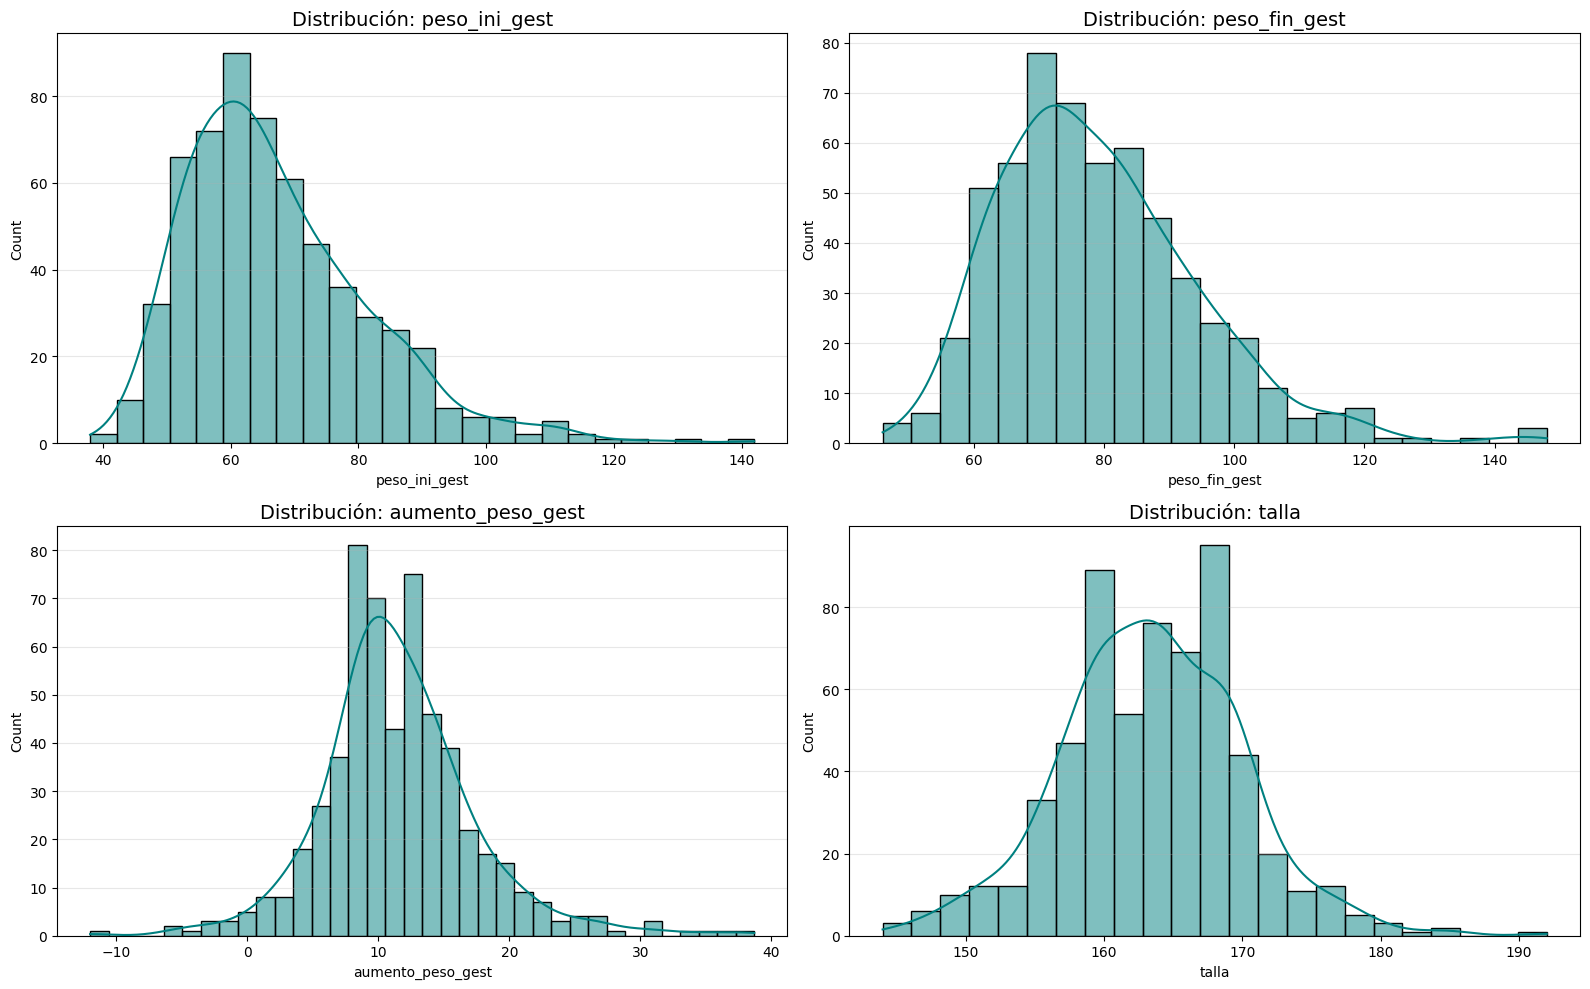

In [218]:
# Seleccionamos una muestra de variables para graficar
plot_nums = [c for c in numeric_cols if 'id' not in c.lower()][:4]

plt.figure(figsize=(16, 10))
for i, col in enumerate(plot_nums, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_filtrado_estadisticas[col].dropna(), kde=True, color='teal')
    plt.title(f'Distribución: {col}', fontsize=14)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Análisis de variables categóricas

In [221]:
# Estadísticas para variables categóricas
stats_cat = pd.DataFrame({
    'total_registros': df_filtrado_estadisticas[categorical_cols].count(),
    'valores_unicos': df_filtrado_estadisticas[categorical_cols].nunique(),
    'moda': df_filtrado_estadisticas[categorical_cols].mode().iloc[0] if not df_filtrado_estadisticas[categorical_cols].empty else "N/A",
    'faltantes_n': df_filtrado_estadisticas[categorical_cols].isnull().sum(),
    'faltantes_pct': (df_filtrado_estadisticas[categorical_cols].isnull().sum() / len(df_filtrado_estadisticas)) * 100
})
print(f"Hay {len(categorical_cols)} variables categóricas para análisis estadístico")
print("Estadísticas categóricas:")
display(stats_cat)

Hay 73 variables categóricas para análisis estadístico
Estadísticas categóricas:


,total_registros,valores_unicos,moda,faltantes_n,faltantes_pct
fecha_firma_ci_cardiomom,587,132,2025-03-26 00:00:00,21,3.453947
fecha_firma_ci_muestbio,587,132,2025-03-26 00:00:00,21,3.453947
fecha_nac,608,581,1986-12-23 00:00:00,0,0.000000
etnia,603,6,0,5,0.822368
concepcion,606,4,0,2,0.328947
...,...,...,...,...,...
valvulopatia,498,3,0,110,18.092105
calidad_del_examen,506,3,Adecuada,102,16.776316
complete,608,2,Complete,0,0.000000
muestra_pelo,580,2,0,28,4.605263


In [222]:
# Exportamanos los resultados a CSV
stats_cat.to_csv('analisis_categorico_exhaustivo.csv')